# Importação de Bibliotecas

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Geração de Dados Sintéticos

In [21]:
# Gerar dados sintéticos
np.random.seed(42)  # Para reprodutibilidade

# Definir o número total de amostras
num_total_samples = 1000

# Gerar características (potência, peso e consumo)
potencia = np.random.uniform(50, 300, num_total_samples)
peso = np.random.uniform(800, 3000, num_total_samples)
consumo = np.random.uniform(5, 20, num_total_samples)

# Gerar classes (0 = Econômico, 1 = Potente)
classes = (potencia + consumo/2 > 200).astype(int)  # Simples regra para classe

# Criar DataFrame
df = pd.DataFrame({
    'Potencia': potencia,
    'Peso': peso,
    'Consumo': consumo,
    'Classe': classes
})

# Funções de Plotagem

In [22]:
# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, title='Matriz de Confusão'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Econômico', 'Potente'], yticklabels=['Econômico', 'Potente'])
    plt.xlabel('Previsão')
    plt.ylabel('Real')
    plt.title(title)

# Função para plotar a curva ROC
def plot_roc_curve(y_true, y_pred_prob, title='Curva ROC'):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)

# Função para plotar a precisão em função de k
def plot_accuracy_vs_k(k_values, accuracies, label, color):
    plt.plot(k_values, accuracies, marker='o', linestyle='-', color=color, label=label)

# Função para plotar a precisão em função do tamanho do treinamento
def plot_accuracy_vs_train_size(train_sizes, accuracies, label, color):
    plt.plot(train_sizes, accuracies, marker='o', linestyle='-', color=color, label=label)

# Função para plotar a fronteira de decisão
def plot_decision_boundary(X, y, clf, title='Fronteira de Decisão'):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=20, label='Dados de Treinamento')
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.title(title)
    plt.legend()
    plt.colorbar(label='Classe')


# Avaliação com Dados Originais

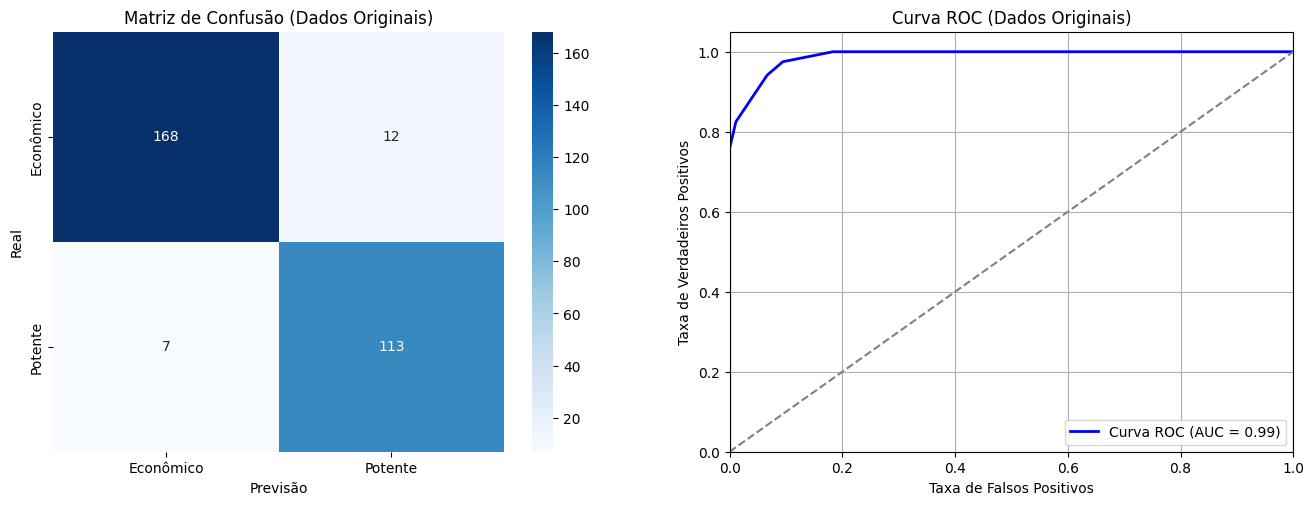

In [23]:
# **Dados Originais**
# Dividir o conjunto de dados em treinamento e teste
X = df[['Potencia', 'Peso', 'Consumo']]
y = df['Classe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criar o classificador kNN com k fixo
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# Treinar o classificador
knn.fit(X_train, y_train)

# Fazer previsões e obter probabilidades
y_pred = knn.predict(X_test)
y_pred_prob = knn.predict_proba(X_test)[:, 1]

# Avaliar e visualizar os resultados nos dados originais
plt.figure(figsize=(16, 12))

# Gráfico 1: Matriz de Confusão
plt.subplot(2, 2, 1)
plot_confusion_matrix(y_test, y_pred, title='Matriz de Confusão (Dados Originais)')

# Gráfico 2: Curva ROC
plt.subplot(2, 2, 2)
plot_roc_curve(y_test, y_pred_prob, title='Curva ROC (Dados Originais)')

# Listar diferentes valores de k para testar
k_values = range(1, 21)  # Testar k de 1 a 20
accuracies_original = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies_original.append(accuracy)

# Listar diferentes tamanhos de amostras de treinamento
train_sizes = range(50, 501, 50)  # Tamanhos de 50 a 500 amostras
accuracies_train_original = []

for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        df[['Potencia', 'Peso', 'Consumo']],
        df['Classe'],
        train_size=size,
        test_size=num_total_samples - size,
        random_state=42
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies_train_original.append(accuracy)


# Padronização dos Dados

Necessidade de Padronização:

Como as escalas das características são desiguais, a padronização é necessária para que cada característica contribua igualmente para o cálculo das distâncias no algoritmo kNN. O kNN é sensível às escalas das características, pois utiliza distâncias para determinar a similaridade entre amostras. Sem padronização, características com maiores magnitudes (como 'Peso') dominariam o cálculo da distância, enquanto características com magnitudes menores (como 'Consumo') teriam menos influência, resultando em uma avaliação distorcida do modelo.

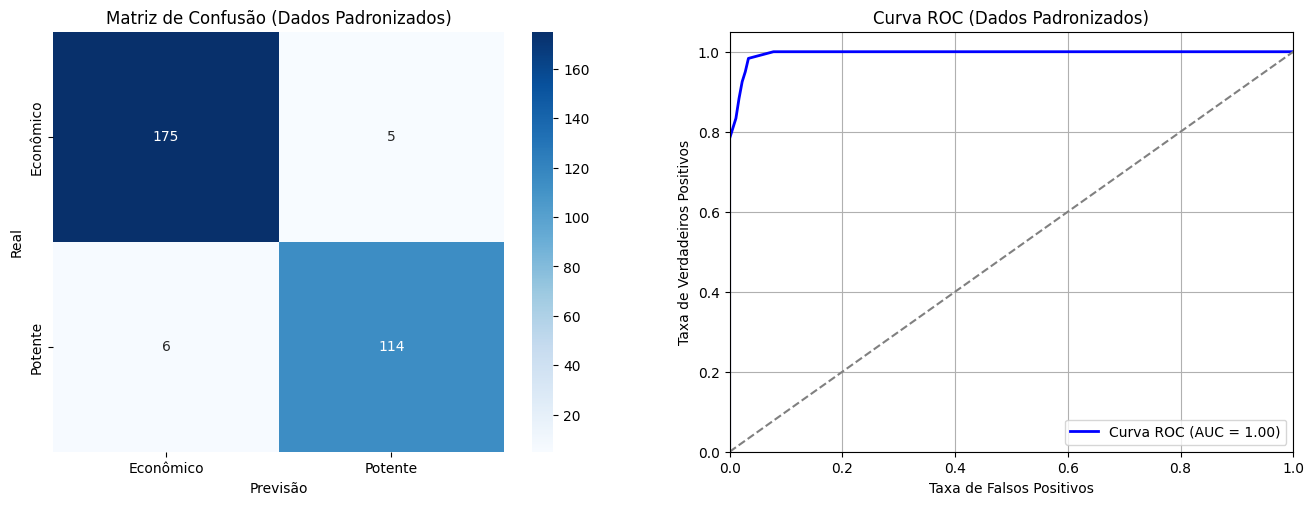

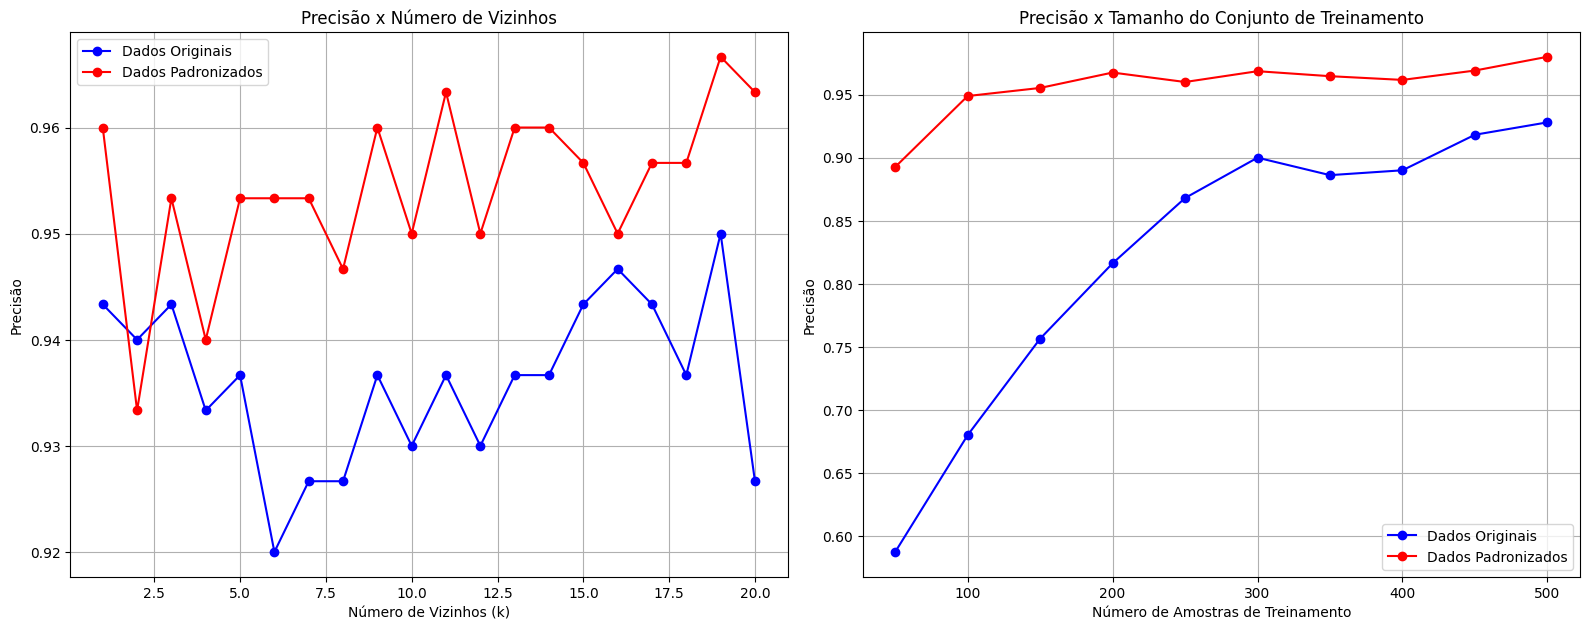

In [24]:
# **Dados Padronizados**
# Aplicar padronização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Potencia', 'Peso', 'Consumo']])
df_scaled = pd.DataFrame(X_scaled, columns=['Potencia', 'Peso', 'Consumo'])
df_scaled['Classe'] = df['Classe']

# Salvar os dados antes e depois da padronização
df.to_csv('dados_originais.csv', index=False)
df_scaled.to_csv('dados_padronizados.csv', index=False)

# Dividir o conjunto de dados padronizados em treinamento e teste
X = df_scaled[['Potencia', 'Peso', 'Consumo']]
y = df_scaled['Classe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar e avaliar o classificador com os dados padronizados
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_prob = knn.predict_proba(X_test)[:, 1]

# Avaliar e visualizar os resultados nos dados padronizados
plt.figure(figsize=(16, 12))

# Gráfico 3: Matriz de Confusão
plt.subplot(2, 2, 1)
plot_confusion_matrix(y_test, y_pred, title='Matriz de Confusão (Dados Padronizados)')

# Gráfico 4: Curva ROC
plt.subplot(2, 2, 2)
plot_roc_curve(y_test, y_pred_prob, title='Curva ROC (Dados Padronizados)')

# Comparar precisão em função de k e tamanho do treinamento para dados padronizados
accuracies_scaled = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies_scaled.append(accuracy)

accuracies_train_scaled = []

for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        df_scaled[['Potencia', 'Peso', 'Consumo']],
        df_scaled['Classe'],
        train_size=size,
        test_size=num_total_samples - size,
        random_state=42
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies_train_scaled.append(accuracy)

# Gráfico Comparativo
plt.figure(figsize=(16, 12))

# Gráfico 1: Precisão x Número de Vizinhos
plt.subplot(2, 2, 3)
plot_accuracy_vs_k(k_values, accuracies_original, 'Dados Originais', 'blue')
plot_accuracy_vs_k(k_values, accuracies_scaled, 'Dados Padronizados', 'red')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Precisão')
plt.title('Precisão x Número de Vizinhos')
plt.legend()
plt.grid(True)

# Gráfico 2: Precisão x Tamanho do Treinamento
plt.subplot(2, 2, 4)
plot_accuracy_vs_train_size(train_sizes, accuracies_train_original, 'Dados Originais', 'blue')
plot_accuracy_vs_train_size(train_sizes, accuracies_train_scaled, 'Dados Padronizados', 'red')
plt.xlabel('Número de Amostras de Treinamento')
plt.ylabel('Precisão')
plt.title('Precisão x Tamanho do Conjunto de Treinamento')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Comentário sobre Resultados:

Matriz de Confusão e Curva ROC:

Dados Originais: A avaliação pode mostrar um desempenho inferior devido às escalas desiguais. A matriz de confusão pode revelar uma maior quantidade de erros, e a curva ROC pode ter um AUC menor.
Dados Padronizados: Após padronização, o desempenho do modelo tende a melhorar, com uma matriz de confusão indicando menos erros e uma curva ROC com AUC mais alto.

Precisão x Número de Vizinhos (k):

Dados Originais vs. Padronizados: A precisão pode variar com k de forma mais estável nos dados padronizados, pois todas as características contribuem igualmente para o cálculo da distância.
Precisão x Tamanho do Treinamento:

Dados Originais vs. Padronizados: Dados padronizados podem mostrar uma precisão mais consistente à medida que o tamanho do treinamento aumenta, indicando uma melhor capacidade do modelo de generalizar com dados variados.

# Conclusão
O notebook demonstrou que a padronização é crucial para o desempenho de algoritmos baseados em distâncias, como o kNN. Ao igualar as escalas das características, a padronização melhora a performance do modelo, como evidenciado pelas métricas de avaliação. A comparação entre dados originais e padronizados revelou que a padronização permite que o classificador kNN avalie todas as características de maneira justa, resultando em uma melhor acurácia e uma avaliação mais consistente das métricas de desempenho. A análise dos gráficos de precisão e fronteira de decisão também confirmou que a padronização é uma prática recomendada para algoritmos de aprendizado de máquina que dependem de distâncias para fazer previsões.